# MFCC from scratch

In [32]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct

## Getting an audio file

In [23]:
audio, sr = librosa.load('/home/joao/Desktop/datasets/data_speech_commands_v0.02/cat/' + 'ffd2ba2f_nohash_0.wav')

## Extracting Short-Time Fourier Transform

In [24]:
FRAME_SIZE = 2048
HOP_SIZE = 512
S_scale = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

## Calculating the spectrogram

In [25]:
Y_scale = np.abs(S_scale) ** 2

## Visualizing the spectrogram 

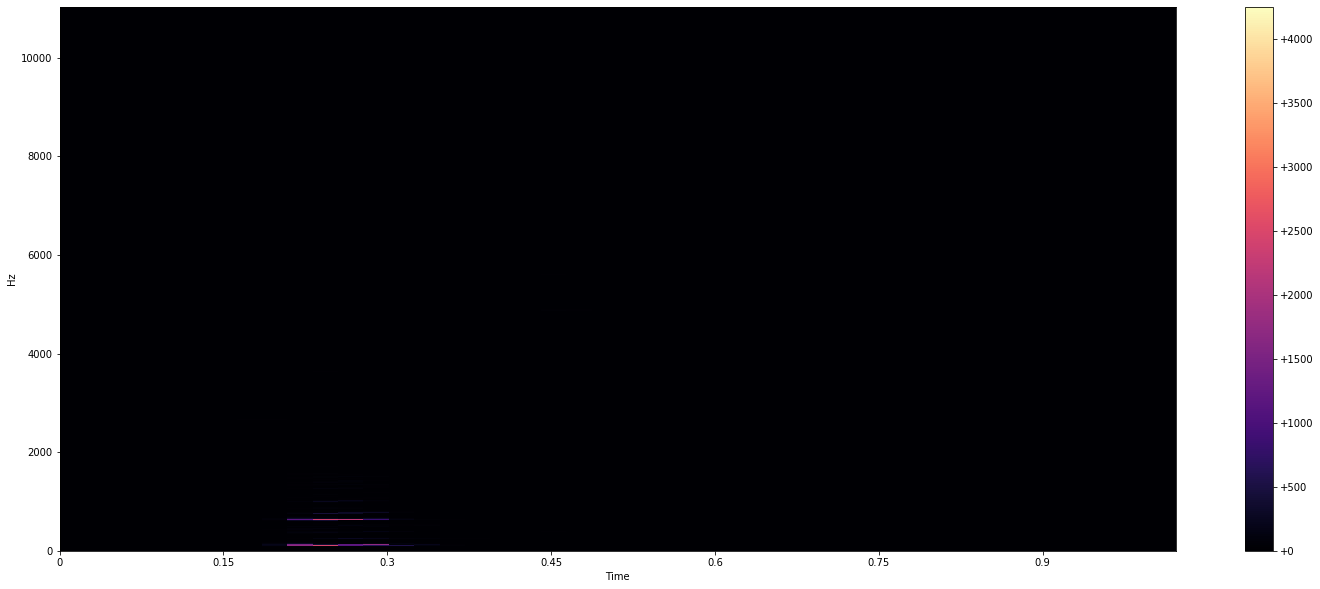

In [15]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

plot_spectrogram(Y_scale, sr, HOP_SIZE)

## Calculating the Mel filter banks

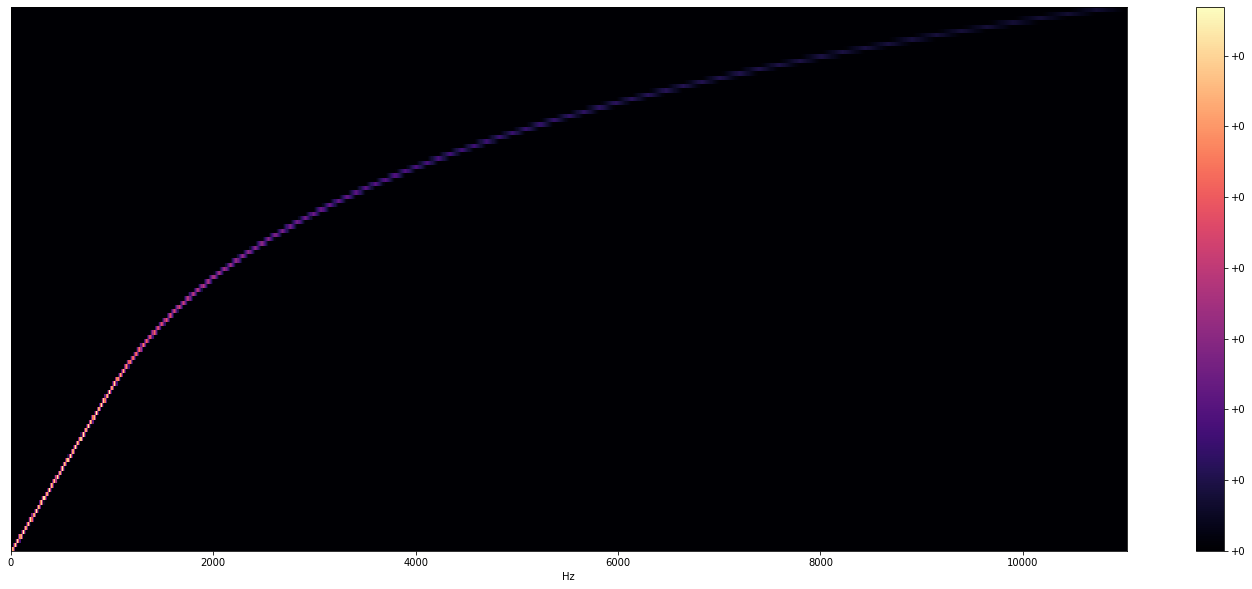

In [27]:
filter_banks = librosa.filters.mel(n_fft=FRAME_SIZE, sr=sr, n_mels=128)
plt.figure(figsize=(25, 10))
librosa.display.specshow(filter_banks, 
                         sr=sr, 
                         x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()

## Computing log-power Mel spectrogram

In [28]:
n_mels = 128

S = librosa.feature.melspectrogram(audio, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=n_mels)

fft_windows = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
magnitude = np.abs(fft_windows)**2
mel = librosa.filters.mel(sr=sr, n_fft=FRAME_SIZE, n_mels=n_mels) # mel == filter_banks
melspectogram = mel.dot(magnitude)

assert (melspectogram == S).all()

In [29]:
melspectogram = librosa.feature.melspectrogram(audio, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=n_mels)
S = filter_banks.dot(Y_scale)
assert (melspectogram == S).all()

## Calculating MFCC

In [30]:
mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S))
# mfccs = librosa.feature.mfcc(y=audio, sr=sr)

## Visualizing MFCC

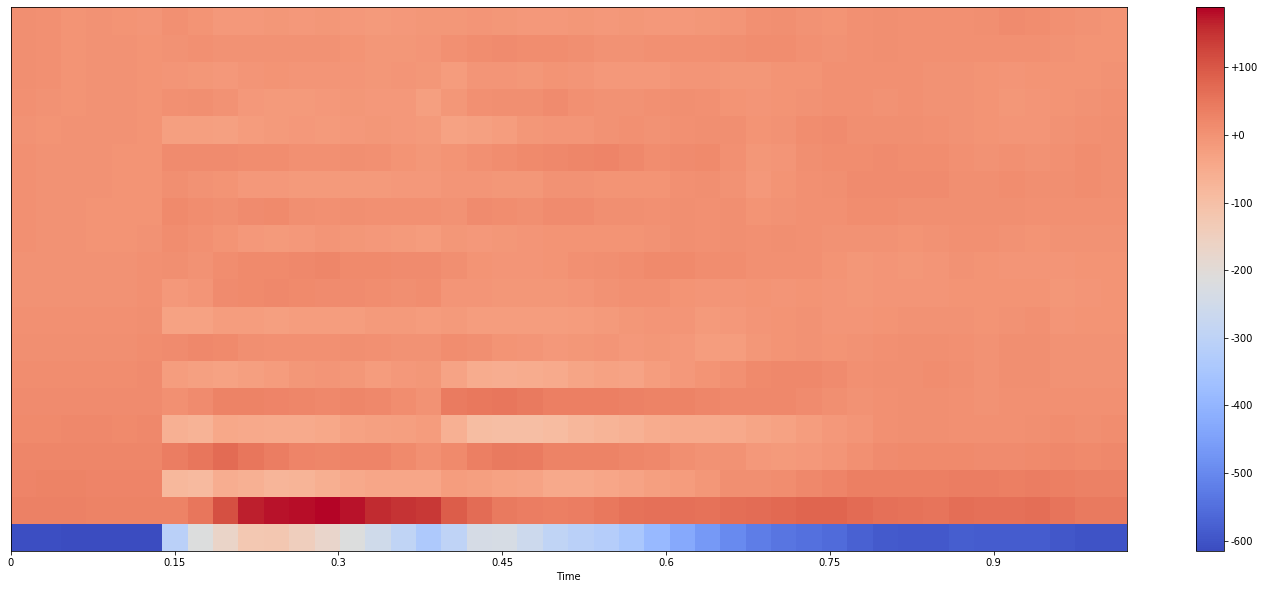

In [31]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [ ]:
def alt_mfcc(audio, sr, n_fft, hop_length, n_mels):
    fft_windows = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(fft_windows)**2
    mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    melspectogram = mel.dot(magnitude)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S))
    return mfccs

In [ ]:
def alt_mfcc(audio, sr, n_fft, hop_length, n_mels, num_ceps=12, cep_lifter=22):
    fft_windows = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(fft_windows)**2
    mel_filter_banks = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    melspectogram = mel_filter_banks.dot(magnitude)
    ##### Getting the MFCC #####
    # mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift  #*
    return mfcc